Задачей проекта является построение модели банковского скоринга по имеющимся данным.

План решения проекта:
1. Первичный осмотр данных (графики пропусков в данных, графики зависимости целевой переменной от признаков)
2. EDA: поиск и заполнение/удаление пропусков, поиск и удаление выбросов, построение матрицы корреляций признаков
3. Построение самой первой наивной модели (baseline для будующих сравнений)
4. Определение важности признаков
5. Эксперименты (логарифмирование числовых значений, новые обработки признаков, создание новых признаков, нормализация)
7. Выбор метрик и гиперпараметров
8. Повторить пункты 4-7

ЕДА - это просто, когда используешь Pandas Profiling!
https://github.com/testdriver87/sf_rds_projects/tree/master/rds_06 

Как пользоваться Pandas Profiling?
https://habr.com/ru/company/ruvds/blog/451478/

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler

import warnings
warnings.filterwarnings('ignore')

In [3]:
def default_boxplot(df, num_cols):
    for column in num_cols:
        plt.figure(figsize=(10,5))
        sns.boxplot(x=df.default, y=df[column])
    
    
def histograms(df, num_cols):
    for column in num_cols:
        plt.figure(figsize=(10,5))
        sns.distplot(df[column], kde=False, rug=False) # kde -- кривая плотности распределения; rug -- штрихи на оси абцисс
        
        
def initial_info(df, cols):
    for column in cols:
        plt.figure(figsize=(10, 5))
        sns.distplot(df[column][df.default==1], rug=False, kde=True, label='default')
        sns.distplot(df[column][df.default==0], rug=False, kde=True, label='no_default')
        plt.legend()
        plt.show()

## 1. Первичный осмотр данных

In [4]:
train = pd.read_csv('train.csv')
train.drop('client_id', axis=1, inplace=True)
display(train.info())
display(train.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   education         73492 non-null  object
 1   sex               73799 non-null  object
 2   age               73799 non-null  int64 
 3   car               73799 non-null  object
 4   car_type          73799 non-null  object
 5   decline_app_cnt   73799 non-null  int64 
 6   good_work         73799 non-null  int64 
 7   bki_request_cnt   73799 non-null  int64 
 8   home_address      73799 non-null  int64 
 9   work_address      73799 non-null  int64 
 10  income            73799 non-null  int64 
 11  foreign_passport  73799 non-null  object
 12  default           73799 non-null  int64 
dtypes: int64(8), object(5)
memory usage: 7.3+ MB


None

education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
bki_request_cnt       0
home_address          0
work_address          0
income                0
foreign_passport      0
default               0
dtype: int64

<AxesSubplot:>

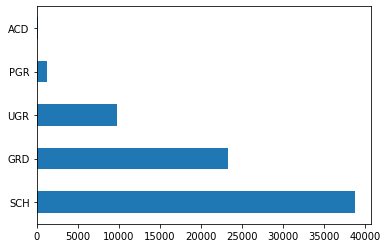

In [5]:
train['education'].value_counts().plot.barh()

In [6]:
train['education'].fillna('SCH', inplace=True)

In [7]:
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']

cat_cols = ['education', 'work_address', 'home_address']

num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']

edu_dict = {'SCH':1, 'GRD':2, 'UGR':3, 'PGR':4, 'ACD':5}

In [9]:
for column in num_cols:
    train[column] = train[column].apply(lambda x: np.log(x + 1))

In [10]:
label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    
# убедимся в преобразовании    
train.head()

,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,SCH,1,4.143135,1,1,0.000000,0,0.693147,1,2,9.798183,0,0
1,SCH,0,4.094345,0,0,0.000000,0,1.386294,2,3,9.852247,0,0
2,SCH,1,3.258097,1,0,1.098612,0,0.693147,1,2,10.308986,1,0
3,SCH,0,3.988984,0,0,0.000000,0,1.098612,2,3,9.210440,0,0
4,GRD,1,3.891820,0,0,0.000000,1,0.693147,2,3,10.308986,1,0


In [15]:
train.education = train.education.apply(lambda x: edu_dict[x])

<AxesSubplot:>

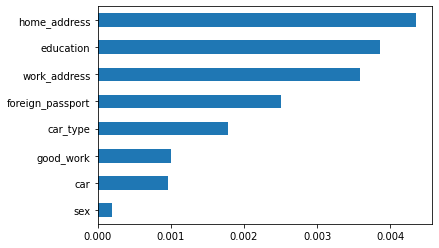

In [16]:
imp_cat = pd.Series(mutual_info_classif(train[bin_cols + cat_cols], train['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [17]:
X_cat = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values)

In [18]:
X_num = StandardScaler().fit_transform(train[num_cols].values)

In [19]:
X = np.hstack([X_num, train[bin_cols].values, X_cat])
Y = train['default'].values

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

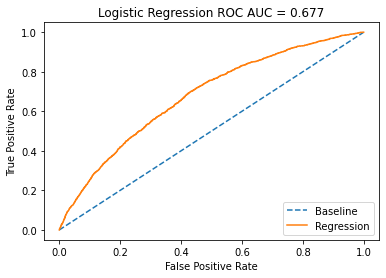

In [24]:
model = LogisticRegression()
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]
y_pred = model.predict(X_test)


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [25]:
metrics.precision_score(y_test, y_pred)

0.5

In [26]:
metrics.recall_score(y_test, y_pred)

0.002736726874657909

In [27]:
metrics.f1_score(y_test, y_pred)

0.005443658138268917